# Boston Housing Prices Dataset 

## Contents

0. [Introduction](#intro)
1. [Pre-processing and Splitting Data](#split)
2. [Models for median price predictions](#model)
3. [Stacked model](#stack)

## Introduction <a class="anchor" id="intro"></a>

This notebook illustrates the use of the `Stacker` to conveniently stack models over folds to perform predictions. In this example, the Boston Housing dataset (included in scikit-learn) is used. Two linear models (Ridge Regression and LASSO) are stacked. The single stacker is a Ridge Regression model. 

In [25]:
import warnings
import numpy as np 
import pandas as pd 

from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedKFold, KFold, ParameterGrid, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler

# Stacking
from Pancake.Stacker import *

# Data
from sklearn.datasets import load_boston

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

warnings.filterwarnings('ignore')

# Random seed
seed=123


## Data Loading and Pre-processing <a class="anchor" id="split"></a>

In [26]:
# Get data
boston=load_boston()

X = boston['data']
y = boston['target']

In [27]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Features and target variables:

In [28]:
feats = boston["feature_names"]
df_boston = pd.DataFrame(X, columns=feats)
df_boston['MEDV'] = y

In [29]:
# Unique values for each feature
df_boston.apply(lambda x: len(set(x)))

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
MEDV       229
dtype: int64

The following features benefit from a log transform:

* `CRIM`, `DIS`, `LSTAT`

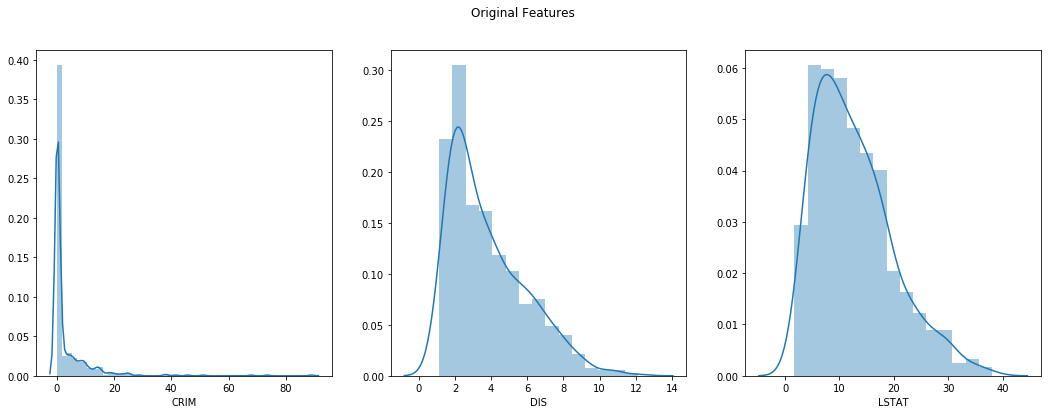

In [30]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
sns.distplot(df_boston['CRIM'],ax=ax1)
sns.distplot(df_boston['DIS'], ax=ax2)
sns.distplot(df_boston['LSTAT'],ax=ax3)
plt.suptitle('Original Features')
plt.show()

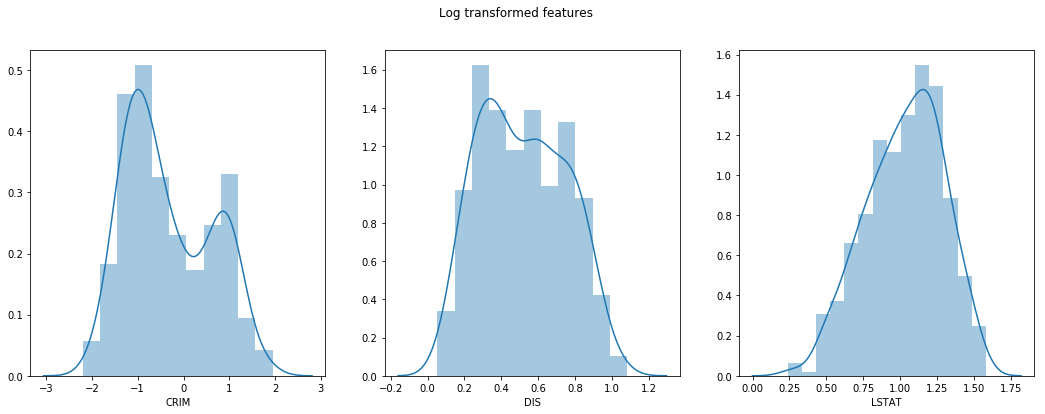

In [31]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
sns.distplot(df_boston['CRIM'].apply(lambda x: np.log10(x)),ax=ax1)
sns.distplot(df_boston['DIS'].apply(lambda x: np.log10(x)), ax=ax2)
sns.distplot(df_boston['LSTAT'].apply(lambda x: np.log10(x)),ax=ax3)
plt.suptitle('Log transformed features')
plt.show()

To split the data into train/test sets, we can stratify using `MEDV` percentiles. This helps in a more balanced distribution between train and test sets

In [32]:
def quantileClasses(y, percs=[25,50,75]):
    quantiles = np.percentile(y, percs)
    yq = np.zeros_like(y,dtype=int)
    
    # Categorical yq based on quantiles
    yq[(y>quantiles[0]) & (y < quantiles[1])] = 1
    yq[(y>quantiles[1]) & (y < quantiles[2])] = 2
    yq[(y>quantiles[2])] = 3
    
    return yq

In [33]:
yq = quantileClasses(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=yq, test_size=0.25, random_state=seed)

Let's pre-process and use robust scaler to re-scale:

In [34]:
feats_toLog = ['CRIM','DIS','LSTAT']
df_train = pd.DataFrame(X_train, columns=feats)
df_test = pd.DataFrame(X_test, columns=feats)

for f in feats_toLog:
    df_train[f] = np.log10(df_train[f])
    df_test[f] = np.log10(df_test[f])

Let's also rescale the features (except the categorical `CHAS`):

In [35]:
feats_to_normalize = [f for f in feats if f != 'CHAS']
X_ = df_train[feats_to_normalize].values

# Scale training data
scaler = RobustScaler()
X_rscl = scaler.fit_transform(X_)

center_, scale_ = scaler.center_, scaler.scale_

Training and test sets:

In [36]:
# Train 
df_train_new = pd.DataFrame(X_rscl, columns=feats_to_normalize)
df_train_new['CHAS'] = df_train['CHAS']

# Test
X_ = df_test[feats_to_normalize].values
X_ = (X_ - center_) / scale_

df_test_new = pd.DataFrame(X_, columns=feats_to_normalize)
df_test_new['CHAS'] = df_test['CHAS']

## Modeling <a class="anchor" id="model"></a>

As a simple case, let's use Ridge Regression and LASSO as in-layer models. We will train both models separately in all training data, as well as on folds for the stacked model

In [37]:
X_train = df_train_new[feats].values
X_test = df_test_new[feats].values

#### Ridge Regression

In [38]:
skf = RepeatedKFold(n_repeats=10,n_splits=5,random_state=seed)
regMod_1 = RidgeCV(alphas=np.logspace(-2,2,100), scoring='neg_mean_squared_error', cv=skf)
regMod_1.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000e-02, 1.09750e-02, ..., 9.11163e+01, 1.00000e+02]),
    cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a26c0b908>,
    fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [39]:
print("Best hyper-parameter: alpha = {:.4f}".format(regMod_1.alpha_))

Best hyper-parameter: alpha = 1.1498


In [40]:
# Predict on train/test sets
y_pred_tr = regMod_1.predict(X_train)
mse_tr = mean_squared_error(y_train, y_pred_tr)

y_pred_ts = regMod_1.predict(X_test)
mse_ts = mean_squared_error(y_test, y_pred_ts)

In [41]:
# Performance
print("Training RMSE = {:.4f}".format(np.sqrt(mse_tr)))
print("Test RMSE = {:.4f}".format(np.sqrt(mse_ts)))

Training RMSE = 4.0275
Test RMSE = 4.7609


#### Lasso

In [42]:
skf = RepeatedKFold(n_repeats=10,n_splits=5,random_state=seed)
regMod_2 = LassoCV(n_alphas=100, cv=skf)
regMod_2.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True,
    cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a26c4ca58>,
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100,
    n_jobs=None, normalize=False, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [43]:
print("Best hyper-parameter: alpha = {:.4f}".format(regMod_2.alpha_))

Best hyper-parameter: alpha = 0.0185


In [44]:
# Train/test predictions
y_pred_tr = regMod_2.predict(X_train)
mse_tr = mean_squared_error(y_train, y_pred_tr)

y_pred_ts = regMod_2.predict(X_test)
mse_ts = mean_squared_error(y_test, y_pred_ts)

In [45]:
# Performance
print("Training RMSE = {:.4f}".format(np.sqrt(mse_tr)))
print("Test RMSE = {:.4f}".format(np.sqrt(mse_ts)))

Training RMSE = 4.0312
Test RMSE = 4.7518


## Stacking <a class="anchor" id="stack"></a>

We can now stack predictions from the above models. We choose to re-train the in-layer models over the folds since it leads to better performance

In [46]:
# Metric to maximize (negative RMSE)
def nrmse(y,y_pred):
    return -np.sqrt(mean_squared_error(y,y_pred))

# Folds
splt = KFold(n_splits=5,random_state=seed)

# Initiate stacker
stacker = Stacker(X_train, y_train, splitter=splt, evalMetric=nrmse, family="regression")

# Hyper-parameters
hypers = {'alpha':np.logspace(-2,2,100)}

# Add one in-layer model
stacker.addModelIn(Ridge(), trainable = True, hyperParameters = hypers)
stacker.addModelIn(Lasso(), trainable = True, hyperParameters = hypers)

# Add one out-layer model
stacker.addModelOut(Ridge(), hypers)

# Train
predsTrain = stacker.stackTrain()

# Test
predsTest = stacker.stackTest(X_test)

In-layer model : 1 trained, Avg CV score across HO folds: -4.2876
In-layer model : 2 trained, Avg CV score across HO folds: -4.2849
Out-layer model : 1 trained,  CV score = -4.2317


In [47]:
# Train/Test set predictions and performance
mse_tr = mean_squared_error(y_train, predsTrain[0])
rmse_tr = np.sqrt(mse_tr)
print("Ridge Regression RMSE (train) = {:.4f}".format(rmse_tr))

mse_ts = mean_squared_error(y_test, predsTest[0])
rmse_ts = np.sqrt(mse_ts)
print("Ridge Regression RMSE (test) = {:.4f}".format(rmse_ts))

Ridge Regression RMSE (train) = 4.2571
Ridge Regression RMSE (test) = 4.7401


This result is better than single models trained on all data. Also, the difference between the training and test set performance is lower.

Let's now use the summary method of the stacker to get some more information:

In [48]:
stacker.summary()

Stacked Model Summary:
----------------------------------------
2 in-layer models stacked in 2.26e+00 sec
1 out-layer models trained in 3.10e-01 sec
In-layer summary
----------------------------------------
2 in-Layer models trained/fitted
Out-layer summary
----------------------------------------
Out-layer model 1: CV score = -4.2317
Best hyper-parameters: {'alpha': 0.25950242113997374}
